Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'USDC'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-07,1.007680,1.001900,1.004100,1.002210,3.829000e+05,1.002210
2018-10-08,1.008330,1.000030,1.004270,1.006860,1.088030e+05,1.006860
2018-10-09,1.019080,1.003970,1.004940,1.009620,7.117830e+05,1.009620
2018-10-10,1.031230,1.001730,1.009940,1.009780,4.177290e+06,1.009780
2018-10-11,1.018710,1.001140,1.008610,1.012720,1.322240e+06,1.012720
...,...,...,...,...,...,...
2021-06-16,1.000799,0.999590,1.000126,1.000717,2.154846e+09,1.000717
2021-06-17,1.001601,0.999764,1.000672,1.001384,2.071078e+09,1.001384
2021-06-18,1.001710,1.000043,1.001412,1.001386,1.592023e+09,1.001386


In [3]:
base_df['Spread'] = base_df.High - base_df.Low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 926 entries, 2018-10-07 to 2021-06-22
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       926 non-null    float64
 1   Low        926 non-null    float64
 2   Open       926 non-null    float64
 3   Close      926 non-null    float64
 4   Volume     926 non-null    float64
 5   Adj Close  926 non-null    float64
 6   Spread     926 non-null    float64
dtypes: float64(7)
memory usage: 57.9 KB


## Plot the closing value of USDCoin over time

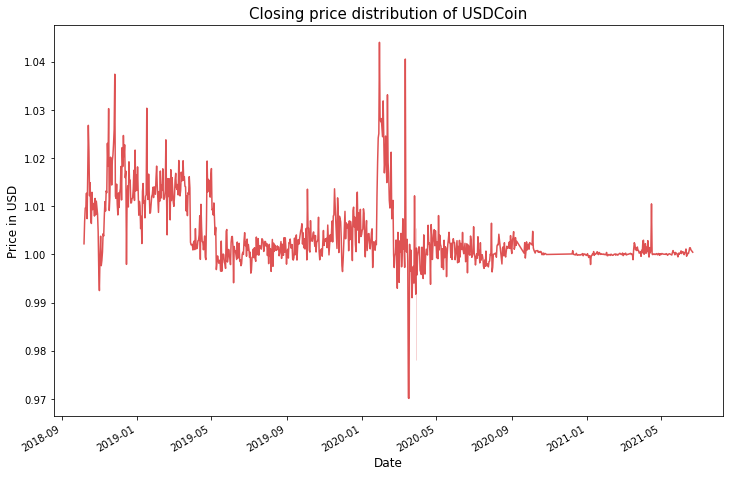

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(y = base_df.Close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of USDCoin", fontsize=15)
plt.show()

## Candlestick chart

In [5]:
import matplotlib.ticker as mticker
import mplfinance as mpf

#base_df['Date_mpl'] = base_df['Date'].apply(lambda x: mdates.date2num(x))

temp_base_df = base_df.copy(deep=False)
#temp_base_df = temp_base_df.set_index(['Date'])
temp_base_df = temp_base_df.drop(['Spread'], axis=1)
temp_base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-07,1.007680,1.001900,1.004100,1.002210,3.829000e+05,1.002210
2018-10-08,1.008330,1.000030,1.004270,1.006860,1.088030e+05,1.006860
2018-10-09,1.019080,1.003970,1.004940,1.009620,7.117830e+05,1.009620
2018-10-10,1.031230,1.001730,1.009940,1.009780,4.177290e+06,1.009780
2018-10-11,1.018710,1.001140,1.008610,1.012720,1.322240e+06,1.012720
...,...,...,...,...,...,...
2021-06-16,1.000799,0.999590,1.000126,1.000717,2.154846e+09,1.000717
2021-06-17,1.001601,0.999764,1.000672,1.001384,2.071078e+09,1.001384
2021-06-18,1.001710,1.000043,1.001412,1.001386,1.592023e+09,1.001386


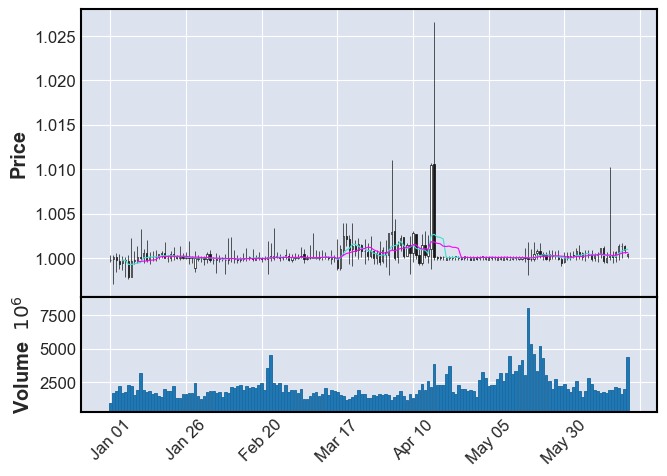

In [6]:
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['Close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
price_predict_df = price_predict_df[price_predict_df['ds']>'2021-1-1']
price_predict_df

,ds,y
755,2021-01-02,1.000162
756,2021-01-03,0.999736
757,2021-01-04,0.999372
758,2021-01-05,0.999749
759,2021-01-06,0.999681
...,...,...
921,2021-06-16,1.000717
922,2021-06-17,1.001384
923,2021-06-18,1.001386
924,2021-06-19,1.000962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
172,2021-06-25,1.001276,1.000231,1.002340
173,2021-06-26,1.000808,0.999634,1.001848
174,2021-06-27,1.000624,0.999381,1.001710
175,2021-06-28,1.000566,0.999280,1.001768
176,2021-06-29,1.000735,0.999338,1.002065


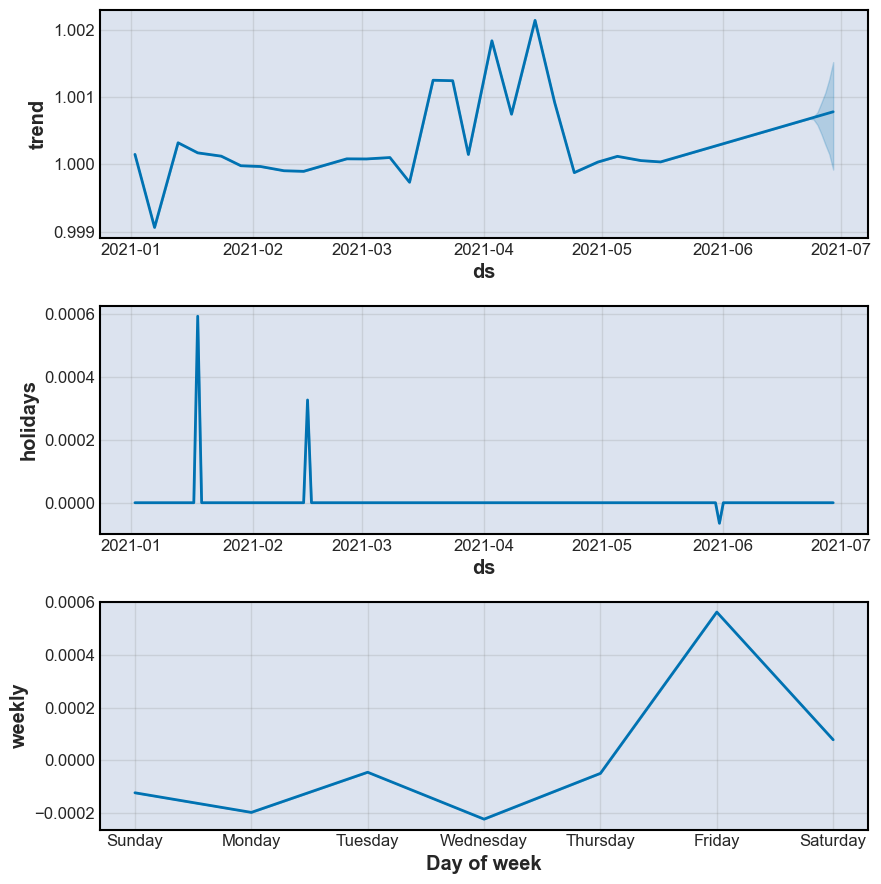

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=7)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

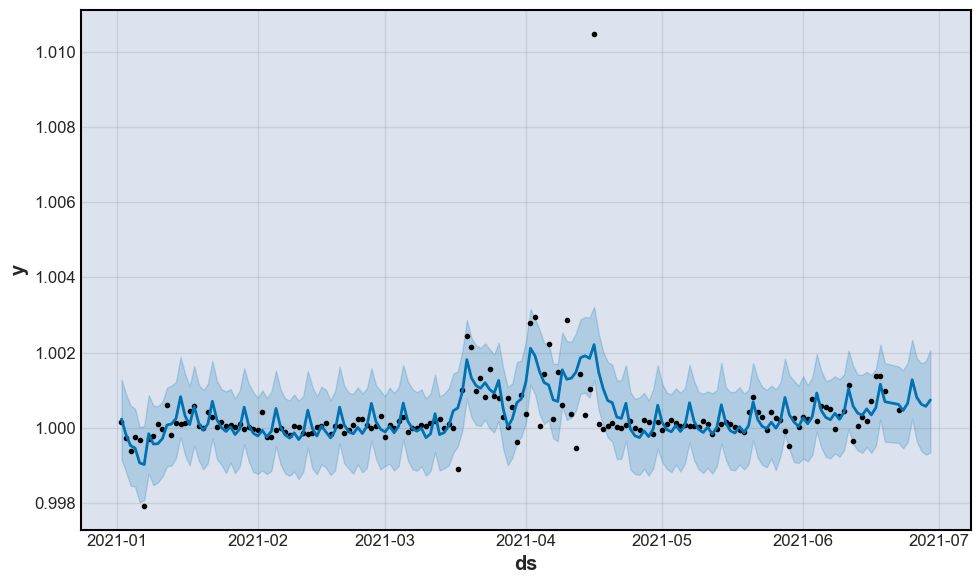

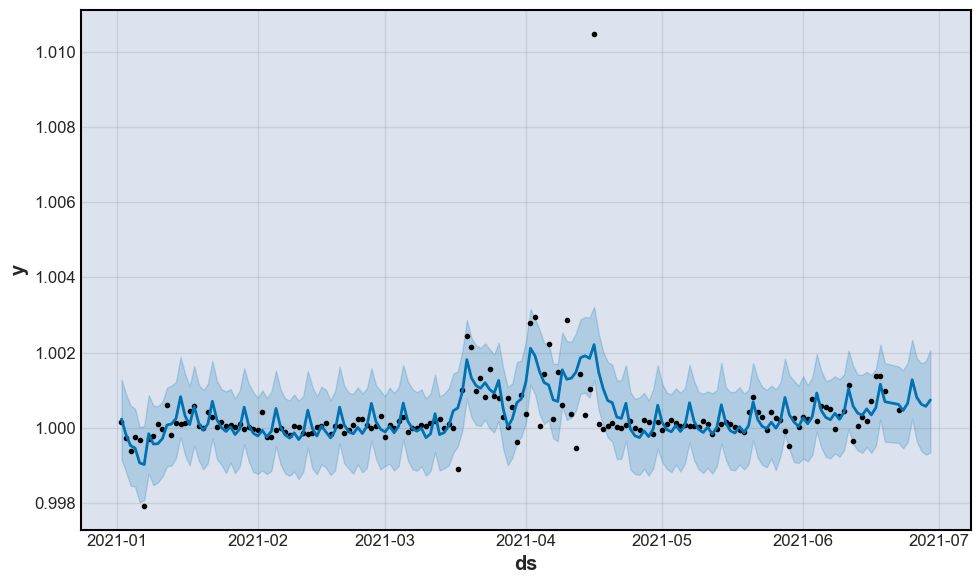

In [10]:
m.plot(forecast)